# Exercises 2.5 - Asset Pricing

In [ ]:
import numpy as np
import scipy as sy
import datetime
from scipy import optimize as opt
import pandas as pd
import pandas_datareader.data as web
import numpy.linalg as lin
from matplotlib import pyplot as plt

In [ ]:
start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2010, 1, 1)

PCECC96 = web.DataReader('PCECC96', 'fred', start, end) 
WILL5000INDFC = web.DataReader('WILL5000INDFC', 'fred', start, end) 
GDPDEF = web.DataReader('GDPDEF', 'fred', start, end)      
TB3MS= web.DataReader('TB3MS', 'fred', start, end)         

#w5000INDFC.fillna(method="ffill")

# Transform the Wilshire 5000 series & T-Bill series into quarterly data. The start of the quarter.
WILL5000INDFC = w5000INDFC.resample('QS').mean()
TB3MS = rfr_tb3MS.resample('QS').mean()

df = pd.DataFrame({'PCECC96': PCECC96["PCECC96"],
                   'WILL5000INDFC': WILL5000INDFC["WILL5000INDFC"],
                  'TB3MS': TB3MS["TB3MS"],
                  'GDPDEF': GDPDEF["GDPDEF"]})

# Account for inflation. (gdpdeflator = (nominal/real) * 100)
df["GDPDEF"] = df["GDPDEF"] / 100 
df["WILL5000INDFC_d"] = df["WILL5000INDFC"] / df["GDPDEF"]


df['R'] = df["WILL5000INDFC_d"].shift(-1) / df["WILL5000INDFC_d"]

# drop NaN variables.  This drops the row is there is a NaN value in the row.
df = df.dropna()

df.shape[0]
len(df)

In [ ]:
# Part 1 - GMM for finding gamma
beta = 0.99

def find_m(gamma):
    return beta * ((df["PCECC96"].shift(-1) ** (-gamma)) / (df["PCECC96"] ** (-gamma)))

def equation_5(gamma):
    df['m'] = find_m(gamma)
    df_temp = df.copy().dropna()
    df_temp['eq_five'] = (df_temp['m'].cov(df_temp['R']) + df_temp['m'].mean()*df_temp['R'].mean() - 1)
    return df_temp['eq_five'].values @ df_temp['eq_five'].values

#opt.broyden1(equation_5, 1)  # I can't get the broyden to work.  Maybe it's requiring a certain method.
opt.root(equation_5, 1)


Part 2: To determine if this parameter is reasonable we would plug it in our utility function and uprime function to see if utility is distributed reasonably.  If we do this, we get decreasing marginal return.  In this model we hate life, because utility is negative but consumption lets us hate life less.  (Since utility is all arbitrary this is a weak argument.)

In [ ]:
# Part 3:  
df['TB3MS'] = TB3MS/100. + 1    # Convert to percentage and make a gross return

def equation_7(gamma):
    df['m'] = find_m(gamma)
    df_temp = df.copy().dropna()
    df_temp['eq_7'] = (df_temp['TB3MS'] - 1/df['m'])
    return df_temp['eq_7'].values @ df_temp['eq_7'].values

#opt.broyden1(equation_7, 1)  # I can't get the broyden to work.  Maybe it's requiring a certain method.
opt.root(equation_7, 0.8)

In [ ]:
# Part 4: 
def find_m2(gamma, beta):
    return beta * ((df["PCECC96"].shift(-1) ** (-gamma)) / (df["PCECC96"] ** (-gamma)))

def GMM_error(params):
    gamma, beta = params
    df['m'] = find_m2(gamma, beta)
    df_temp = df.copy().dropna()
    error = np.zeros(2)
    error[0] = (df_temp['m'].cov(df_temp['R']) + df_temp['m'].mean()*df_temp['R'].mean() - 1)
    error[1] = np.sum(abs((df_temp['TB3MS'] - 1/df['m'])))
    return error

def criterion(params, *args):
    gamma, beta = params
    W = args
    error = GMM_error(params)
    return error.T @ W @ error

W_temp = np.eye(2)
params_init = np.array([1.5, 1])
gmm_args = W_temp
output1 = opt.minimize(criterion, params_init, args = (gmm_args), method= 'L-BFGS-B', bounds = ((1e-6, None), (1e-6, None)))
gamma1, beta1 = output1.x
err = GMM_error((gamma1, beta1)) 
W_hat = lin.pinv(np.outer(err, err.T) / len(df['TB3MS']))
gmm_args = W_hat
opt.minimize(criterion, params_init, args = (gmm_args), method= 'L-BFGS-B', bounds = ((1e-6, None), (1e-6, None)))
# Gamma is definitely wrong in this but I can't figure out why.

In [ ]:
gamma_xspace = np.linspace(1e-6, 4, 100)
beta_xspace = np.linspace(0.93, 0.99, 10)
gmm_values = np.zeros((100, 100))
for i in range(len(gamma_xspace)):
    for j in range(len(beta_xspace)):
        params = (gamma_xspace[i], beta_xspace[j])
        gmm_values[i, j] = criterion(params, W_hat)

In [ ]:
for j in range(len(beta_xspace)):
    plt.plot(gamma_xspace, gmm_values[:, j], label=rf'$beta$ = {beta_xspace[j]:.2f}')
plt.xlabel('gamma')
plt.legend()
plt.show()

# Exercises 3.5 - Kyle Model

In [ ]:
%reset

In [306]:
import numpy as np
from pprint import pprint
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import statsmodels.formula.api as smf
import statsmodels.api as sm
import datetime

In [307]:
AAPL = pickle.load(open('AAPL', 'rb'))
C = pickle.load(open('C', 'rb'))
GBX = pickle.load(open('GBX', 'rb'))
SPY = pickle.load(open('SPY', 'rb'))
THO = pickle.load(open('THO', 'rb'))

In [312]:
class Orderbook:

    def __init__(self, data, title):
        self.time = data[0]
        self.title = title
        
        
        # Clean the data.  Thanks to the help of Matt, who had help from Reiko, who had help from ...
        df = pd.DataFrame.from_dict(data[1], orient='index')
        df = df.sort_index()
        df = df.reset_index()
        df.columns = ['Price', 'Quantity', 'Side', 'X', 'Y']
        df = df.drop(['X', 'Y'], axis = 1)
        
        df['Cumulative Quantity'] = df["Quantity"].cumsum()
        Qmkt = np.max(df['Cumulative Quantity'][df['Side'] == 'B'])
        Pmkt = df['Price'][(df['Cumulative Quantity'][df['Side'] == 'B']).idxmax()]
        df['Cumulative Quantity'] = df['Cumulative Quantity'] - Qmkt
        self.Pmkt = Pmkt
        
        self.data = df
        self.data10 = df[(df.Price >= self.Pmkt *0.9) & (df.Price <= self.Pmkt*1.1)]
        
    def estimating(self):
        self.data10['Ones'] = np.ones(len(self.data10['Price']))
        P = self.data10[['Ones', 'Price']]
        y = self.data10['Cumulative Quantity']
        gamma, beta = np.linalg.lstsq(P, y, rcond=None)[0]

        return gamma, beta
    
    def plot_fun(self):
        plt.plot(self.data10['Price'], self.data10['Cumulative Quantity'])
        plt.title(f"The Order Book of {self.title} at t = {self.time}")
        plt.xlabel("Price")
        plt.ylabel("Cumulative Quantity")
        gamma, beta = self.estimating()
        xgrid = np.linspace(0.9* self.Pmkt, 1.1*self.Pmkt, 100)
        plt.plot(xgrid, gamma + beta*xgrid, label = 'equation 10' )
        
        plt.show()

/Users/cacheellsworth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


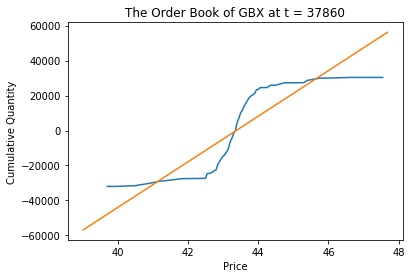

In [313]:
book1 = Orderbook(GBX[60], 'GBX')
book1.plot_fun()

/Users/cacheellsworth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


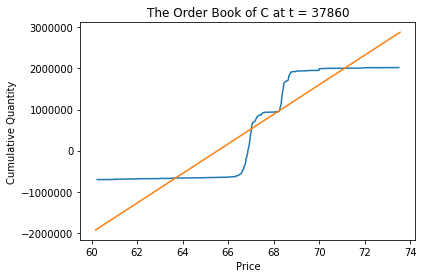

In [314]:
book2 = Orderbook(C[60], 'C')
book2.plot_fun()

/Users/cacheellsworth/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


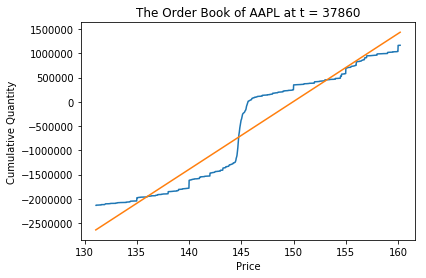

In [315]:
book3 = Orderbook(AAPL[60], 'AAPL')
book3.plot_fun()

The model fits well with only a part of the data in each orderbook.  Usually the linear model, does well but in some of the models seperating the linear models might work better ( like for C).

In [ ]:
# Part 2

In [ ]:
#  I followed matt's code to load in the data where he loads in a certain time. 
# If there's time later, redo the class into only one class to make it less messy.
class Asset:
    
    def __init__(self, asset, title):
        n = len(asset)
        self.price = []
        self.time = []
        self.p_0 = []
        self.beta = []
        self.title = title
        
        for i in range(len(asset)):
            book = Orderbook(asset[i], title)
            
            gamma, beta = book.estimating()
            
            
            self.p_0.append(- gamma / beta)
            self.time.append(book.time)
            self.price.append(book.Pmkt)
            self.beta.append(beta)
            
    def plot_day(self):
        plt.plot(self.time, self.price, label="Original Price")
        plt.plot(self.time, self.beta, label = "Beta's of 10%")
        plt.xlabel("Time")
        plt.ylabel("Beta Values")
        plt.show()

In [ ]:
tickers = ['AAPL', 'C', 'SPY', 'GBX', 'THO']
book_AAPL = Asset(AAPL, 'AAPL')
book_C = Asset(C, 'C')
book_SPY = Asset(SPY, 'SPY')
book_GBX = Asset(GBX, 'GBX')
book_THO = Asset(THO, 'THO')

In [ ]:
book_AAPL.plot_day()

I can't get this to run.  It acts like it is running but I don't think it is.  It's time to cut my losses.